In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import shap
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from torchvision import transforms
import seaborn as sns
import sys
# 📁 현재 노트북 위치 기준으로 상위 폴더 경로 계산
current_dir = os.path.dirname(os.path.abspath("__file__"))
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir, os.pardir))  # ../
sys.path.append(parent_dir)
from dataset.FF import FaceForensicsDataset
from model.DefocusNet_backbone_defocus_gt import DefocusMapGenerator  # 위치에 따라 경로 수정
from model.models import model_selection

# --------------------------- 설정 ---------------------------
FF_RGB_ROOT = "/media/NAS/DATASET/faceforensics++/Dec2020/v1face_data/data_c0"
FAKE_TYPE = "Deepfakes"  # 또는 Face2Face, FaceSwap 등
EPOCHS = 5
BACKBONE = "xception"  # 사용할 백본 모델 (예: xception, resnet50 등)
WEIGHT_PATH = f"defocus_gt_{BACKBONE}_{FAKE_TYPE}.pth"
IMG_SIZE = 299
BATCH_SIZE = 32
LR = 2e-4
WEIGHT_DECAY = 5e-4
SAVE_MAPS_DIR = "./defocus_entropy"
os.makedirs(SAVE_MAPS_DIR, exist_ok=True)

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 인스턴스 생성
defocus_generator = DefocusMapGenerator().to(device)

def normalize_per_sample(x):
        B, C, H, W = x.shape
        x_flat = x.view(B, -1)
        min_val = x_flat.min(dim=1, keepdim=True)[0]
        max_val = x_flat.max(dim=1, keepdim=True)[0]
        norm = (x_flat - min_val) / (max_val - min_val + 1e-8)
        return norm.view(B, C, H, W)
    

# --------------------------- 데이터셋 1 ---------------------------
# ✅ Transform 정의
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])
# ✅ Dataset 준비
real_test_dataset = FaceForensicsDataset(root_dir="/media/NAS/DATASET/faceforensics++/Dec2020/v1face_data/data_c0", phase="real_test_only", fake_types=["Deepfakes"], transform=transform)
fake_test_dataset = FaceForensicsDataset(root_dir="/media/NAS/DATASET/faceforensics++/Dec2020/v1face_data/data_c0", phase="fake_test_only", fake_types=["Deepfakes"], transform=transform)


real_test_loader = DataLoader(real_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
fake_test_loader = DataLoader(fake_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

🔹 [REAL_TEST_ONLY] Deepfakes 이미지 개수: 6400
🔹 [FAKE_TEST_ONLY] Deepfakes 이미지 개수: 6400


# Real Defocus Map Tensor

In [2]:
import tqdm
import numpy as np

real_defocus_maps = []
real_edge_maps = []
real_labels = []
hist_features = []
with torch.no_grad():
    for images, labels, _ in tqdm.tqdm(real_test_loader, desc="Extracting Defocus Maps"):
        images = images.to(device)
        defocus_map_gt, sparse_map, edge_map = defocus_generator(images, device)
        
        # defocus_map_gt = normalize_per_sample(defocus_map_gt)
        real_defocus_maps.append(defocus_map_gt.cpu())
        real_edge_maps.append(edge_map.cpu())
        real_labels.extend(labels.numpy())

# (B, 1, H, W) → (N, 1, H, W)
real_defocus_maps_tensor = torch.cat(real_defocus_maps, dim=0)
real_edge_maps_tensor = torch.cat(real_edge_maps, dim=0)
real_labels = np.array(real_labels)


Extracting Defocus Maps: 100%|██████████| 200/200 [01:10<00:00,  2.85it/s]


# Fake Defocus Map Tensor

In [3]:
import tqdm
import numpy as np

fake_defocus_maps = []
fake_edge_maps = []
fake_labels = []
with torch.no_grad():
    for images, labels, _ in tqdm.tqdm(fake_test_loader, desc="Extracting Defocus Maps"):
        images = images.to(device)
        defocus_map_gt, sparse_map, edge_map = defocus_generator(images, device)
        
        # defocus_map_gt = normalize_per_sample(defocus_map_gt)
        fake_defocus_maps.append(defocus_map_gt.cpu())
        fake_edge_maps.append(edge_map.cpu())
        fake_labels.extend(labels.numpy())



# (B, 1, H, W) → (N, 1, H, W)
fake_defocus_maps_tensor = torch.cat(fake_defocus_maps, dim=0)  # 텐서로 합침
fake_edge_maps_tensor = torch.cat(fake_edge_maps, dim=0)  # 텐서로 합침
fake_labels = np.array(fake_labels)  # 라벨을 numpy 배열로 변환

print(fake_defocus_maps_tensor.shape, fake_edge_maps_tensor.shape)

Extracting Defocus Maps: 100%|██████████| 200/200 [01:38<00:00,  2.02it/s]


torch.Size([6400, 1, 299, 299]) torch.Size([6400, 1, 299, 299])


In [4]:
fake_defocus_maps_tensor.shape

torch.Size([6400, 1, 299, 299])

In [5]:
fake_defocus_maps_tensor2 = fake_defocus_maps_tensor.repeat(1, 3, 1, 1)[:1000]

real_defocus_maps_tensor2 = real_defocus_maps_tensor.repeat(1, 3, 1, 1)[:1000]  # (N, 3, H, W)


In [6]:
num_samples = 1000

# 🔹 총 샘플 수 확인
total_real = real_defocus_maps_tensor.size(0)
total_fake = fake_defocus_maps_tensor.size(0)

# 🔹 인덱스를 랜덤하게 섞은 후 앞에서 1000개 선택
rand_real_idx = torch.randperm(total_real)[:num_samples]
rand_fake_idx = torch.randperm(total_fake)[:num_samples]

# 🔹 3채널 repeat 후, 랜덤 인덱스로 추출
real_defocus_maps_tensor_rand = real_defocus_maps_tensor[rand_real_idx].repeat(1, 3, 1, 1)  # (1000, 3, H, W)
fake_defocus_maps_tensor_rand = fake_defocus_maps_tensor[rand_fake_idx].repeat(1, 3, 1, 1)  # (1000, 3, H, W)


In [7]:
real_defocus_maps_tensor2.shape

torch.Size([1000, 3, 299, 299])

In [8]:
# 예시: DefocusNet 안에 있는 Xception 불러오기
from model.DefocusNet_backbone_defocus_gt import DefocusNet  # 위치에 따라 경로 수정
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DefocusNet(num_classes=1, backbone=BACKBONE)
model = model.to(device)

print(f"✅ Using backbone: {BACKBONE}")
print(f"✅ Model class: {model.classifier.__class__.__name__}")

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model, device_ids=[0, 1, 3])

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

model.load_state_dict(torch.load('../../weights/defocus_gt_legacy_xception_Deepfakes.pth'))
model.eval().to(device)

# 모델 안에 xception이 이렇게 있다면:
# classifier = model.module.classifier if hasattr(model, 'module') else model.classifier


Mapping deprecated model name xception to current legacy_xception.


✅ Using backbone: xception
✅ Model class: Xception


DataParallel(
  (module): DefocusNet(
    (defocus_generator): DefocusMapGenerator()
    (classifier): Xception(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (block1): Block(
        (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rep): Sequential(
          (0): SeparableConv2d(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (1

torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([40, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([40, 2048])


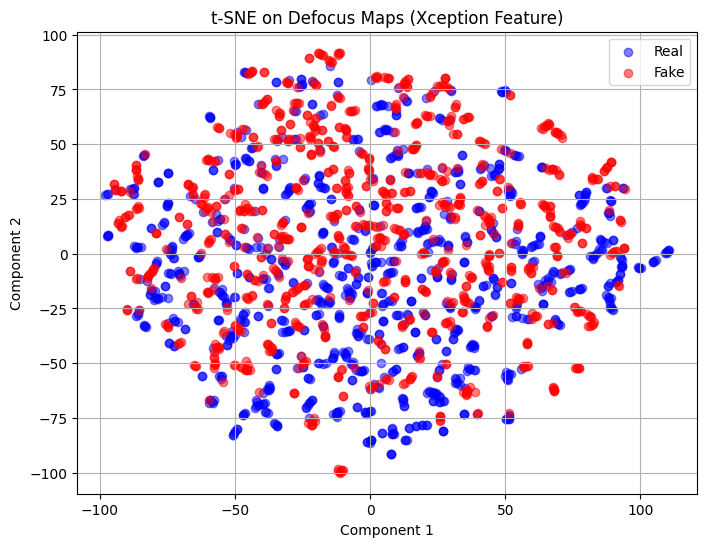

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Step 2: DataLoader로 변환
batch_size = 64
real_loader = DataLoader(TensorDataset(real_defocus_maps_tensor_rand), batch_size=batch_size)
fake_loader = DataLoader(TensorDataset(fake_defocus_maps_tensor_rand), batch_size=batch_size)


# Step 4: Feature 추출
def extract_xception_features(dataloader, backbone_model):
    feats = []
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)

            # Resize to 299x299 (Xception input size)
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

            # Xception forward
            out = backbone_model.forward_features(x)  # (B, 2048)
            # 🔥 Adaptive Average Pooling → (B, 2048, 1, 1)
            out = F.adaptive_avg_pool2d(out, (1, 1))

            # 🔥 Flatten → (B, 2048)
            out = out.view(out.size(0), -1)
            print(out.shape)
            feats.append(out.cpu())
    return torch.cat(feats, dim=0)  # (N, 2048)


# DataParallel을 고려해서 접근
xcep_model = model.module.classifier  # Xception 내부


real_feat = extract_xception_features(real_loader, xcep_model)
fake_feat = extract_xception_features(fake_loader, xcep_model)


# Step 5: t-SNE 실행
all_feat = torch.cat([real_feat, fake_feat], dim=0).numpy()  # (2N, 512)
all_labels = np.concatenate([np.zeros(1000), np.ones(1000)])  # 0: real, 1: fake


tsne = TSNE(n_components=2, perplexity=5, random_state=42)
tsne_result = tsne.fit_transform(all_feat)

# Step 6: 시각화
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[all_labels == 0, 0], tsne_result[all_labels == 0, 1],
            c='blue', alpha=0.5, label='Real')
plt.scatter(tsne_result[all_labels == 1, 0], tsne_result[all_labels == 1, 1],
            c='red', alpha=0.5, label='Fake')
plt.title("t-SNE on Defocus Maps (Xception Feature)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

for p in [5, 10, 20, 40]:
    tsne = TSNE(n_components=2, perplexity=p, random_state=42)
    tsne_result = tsne.fit_transform(all_feat)

    plt.figure(figsize=(6, 5))
    plt.scatter(tsne_result[all_labels == 0, 0], tsne_result[all_labels == 0, 1],
                c='blue', alpha=0.5, label='Real')
    plt.scatter(tsne_result[all_labels == 1, 0], tsne_result[all_labels == 1, 1],
                c='red', alpha=0.5, label='Fake')
    plt.title(f"t-SNE (perplexity={p})")
    plt.legend()

    # 🔥 파일로 저장
    plt.savefig(f"tsne_perplexity_{p}.png", dpi=300, bbox_inches='tight')  # high-resolution
    plt.close()  # 메모리 절약


In [18]:
!pip install umap-learn

Found existing installation: umap 0.1.1
Uninstalling umap-0.1.1:
  Would remove:
    /home/minsun/anaconda3/envs/seg/lib/python3.8/site-packages/umap-0.1.1.dist-info/*
    /home/minsun/anaconda3/envs/seg/lib/python3.8/site-packages/umap/*
Proceed (Y/n)? ERROR: Operation cancelled by user
^C


In [25]:
import umap
import matplotlib.pyplot as plt

# 🔹 UMAP 모델 정의 및 학습
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(all_feat)  # all_feat: (N, 2048)

# 🔹 시각화
plt.figure(figsize=(8, 6))
plt.scatter(umap_result[all_labels == 0, 0], umap_result[all_labels == 0, 1],
            c='blue', alpha=0.5, label='Real')
plt.scatter(umap_result[all_labels == 1, 0], umap_result[all_labels == 1, 1],
            c='red', alpha=0.5, label='Fake')
plt.title("UMAP on DefocusNet-Xception Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.show()


AttributeError: module 'umap' has no attribute 'UMAP'

In [84]:
import torchvision.models as models
import torch.nn as nn

# 사전학습된 ResNet18 사용
resnet = models.resnet18(pretrained=True)
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # 마지막 FC 제거
feature_extractor.eval().to(device)

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [85]:
# 이미지 입력 → 특징 추출
with torch.no_grad():
    real_feat = feature_extractor(real_defocus_maps_tensor.to(device)).squeeze(-1).squeeze(-1)  # (N, 512)
    fake_feat = feature_extractor(fake_defocus_maps_tensor.to(device)).squeeze(-1).squeeze(-1)


RuntimeError: CUDA out of memory. Tried to allocate 34.33 GiB (GPU 0; 23.64 GiB total capacity; 8.68 GiB already allocated; 13.96 GiB free; 8.70 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [78]:
# (N, 1, H, W) -> (N, H * W)
N, _, H, W = fake_defocus_maps_tensor.shape
fake_flatten = fake_edge_maps_tensor.view(N, -1)[:1000]  # (1000, H*W)
real_flatten = real_edge_maps_tensor.view(N, -1)[:1000]  # (1000, H*W)


In [66]:
print("Fake Defocus Map Range:")
print("  min:", fake_defocus_maps_tensor.min().item())
print("  max:", fake_defocus_maps_tensor.max().item())


Fake Defocus Map Range:
  min: 0.0
  max: 1.0


In [67]:
print("Fake Defocus Map Range:")
print("  min:", fake_flatten.min().item())
print("  max:", fake_flatten.max().item())


Fake Defocus Map Range:
  min: 0.0
  max: 1.0


In [49]:
print(fake_flatten.shape)

torch.Size([1000, 89401])


In [79]:
all_data = torch.cat([real_flatten, fake_flatten], dim=0)  # (2N, D)
all_labels = np.concatenate([np.zeros(1000), np.ones(1000)])  # 0: real, 1: fake


In [51]:
all_labels.shape

(2000,)

In [72]:
from umap.umap_ import UMAP

umap_model = UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(all_data)  # PCA 후 or normalize 후 사용 가능


n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


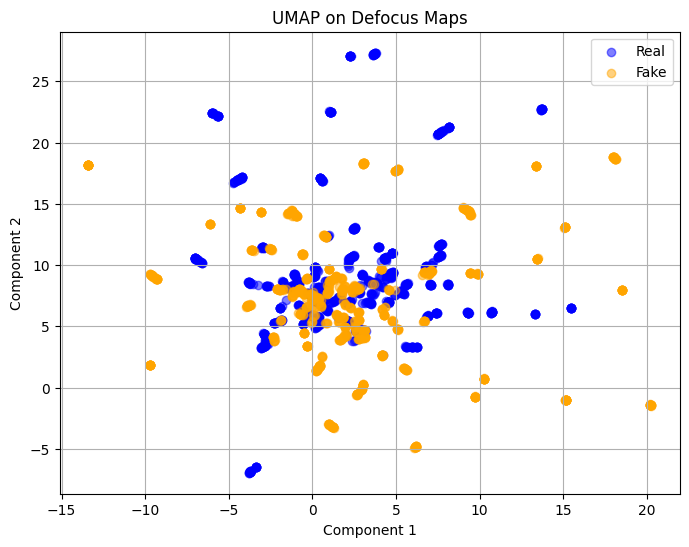

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(umap_result[all_labels == 0, 0], umap_result[all_labels == 0, 1],
            c='blue', alpha=0.5, label='Real')
plt.scatter(umap_result[all_labels == 1, 0], umap_result[all_labels == 1, 1],
            c='orange', alpha=0.5, label='Fake')
plt.title("UMAP on Defocus Maps")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.show()


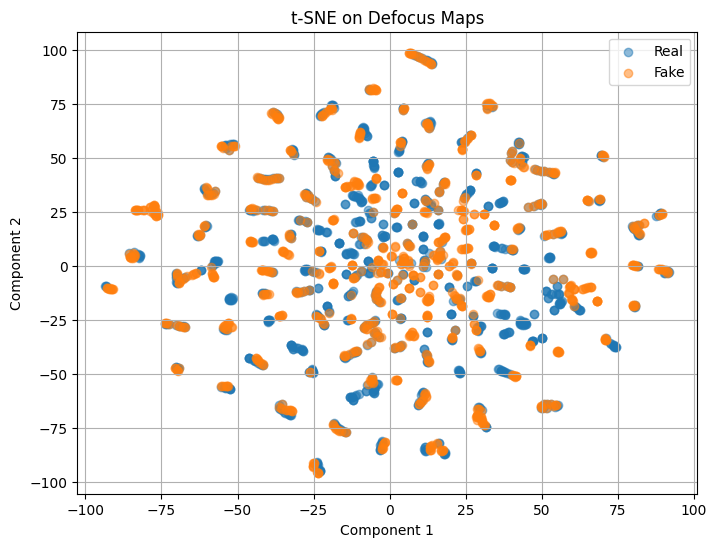

In [80]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
pca_result = pca.fit_transform(all_data.numpy())

tsne = TSNE(n_components=2, perplexity=10, n_iter=1000, learning_rate=100, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

# 시각화
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[all_labels==0, 0], tsne_result[all_labels==0, 1], label='Real', alpha=0.5)
plt.scatter(tsne_result[all_labels==1, 0], tsne_result[all_labels==1, 1], label='Fake', alpha=0.5)
plt.legend()
plt.title('t-SNE on Defocus Maps')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()
